In [26]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import seaborn as sns
from sklearn.feature_selection import SelectKBest,f_classif

In [27]:
import warnings
warnings.simplefilter("ignore")

# LOAD DATA

In [28]:
DATA_PATH = "BazaCut/"
FILIP_PATH = DATA_PATH + "wordsFilip/"
SEB_PATH = DATA_PATH + "wordsSebastian/"
MARCIN_PATH = DATA_PATH + "wordsMarcin/"
PROF_PATH = DATA_PATH + "wordsProfessor/"
no_of_words = 30
prefixes = ["F","S","M","L"]
Fs = 48000
words_filip = [i for i in range(no_of_words)]
words_seb = [i for i in range(no_of_words)]
words_marcin = [i for i in range(no_of_words)]
words_prof = [i for i in range(no_of_words)]

for i in range(1, no_of_words+1):
    file_name = "word"+str(i)+"_F"+".wav"
    y, sr = librosa.load(FILIP_PATH+file_name, sr=None)
    words_filip[i-1] = y

for i in range(1, no_of_words+1):
    file_name = "word"+str(i)+"_S"+".wav"
    y, sr = librosa.load(SEB_PATH+file_name, sr=None)
    words_seb[i-1] = y

for i in range(1, no_of_words+1):
    file_name = "word"+str(i)+"_M"+".wav"
    y, sr = librosa.load(MARCIN_PATH+file_name, sr=None)
    words_marcin[i-1] = y

for i in range(1, no_of_words+1):
    file_name = "word"+str(i)+"_L"+".wav"
    y, sr = librosa.load(PROF_PATH+file_name, sr=None)
    words_prof[i-1] = y


# MFCC (Mel Frequency Cepstral Coefficients) and Deltta MFCC

In [29]:
# Ekstrakcja MFCC (np. 13 współczynników)
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# Dodatkowe cechy: delty MFCC
delta_mfcc = librosa.feature.delta(mfcc)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

# Połączenie cech w jedną macierz
features = np.concatenate([mfcc, delta_mfcc, delta2_mfcc], axis=0)

mfcc_features_no = 13
#Problem: w wyniku mfcc mamy macierz (13,x). Ilość kolumn dla każdego słowa jest inna. Nie da się 
#dać do numpy array
mfcc_filip = [i for i in range(no_of_words)]
mfcc_delta_filip = [i for i in range(no_of_words)]
mfcc_delta2_filip = [i for i in range(no_of_words)]
for i, word in enumerate(words_filip):
    mfcc_filip[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
    mfcc_delta_filip[i] = librosa.feature.delta(mfcc_filip[i])
    mfcc_delta2_filip[i] =  librosa.feature.delta(mfcc_filip[i], order=2)


mfcc_seb = [i for i in range(no_of_words)]
mfcc_delta_seb = [i for i in range(no_of_words)]
mfcc_delta2_seb = [i for i in range(no_of_words)]
for i, word in enumerate(words_seb):
    mfcc_seb[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
    mfcc_delta_seb[i] = librosa.feature.delta(mfcc_seb[i])
    mfcc_delta2_seb[i] =  librosa.feature.delta(mfcc_seb[i], order=2)

mfcc_marcin = [i for i in range(no_of_words)]
mfcc_delta_marcin = [i for i in range(no_of_words)]
mfcc_delta2_marcin = [i for i in range(no_of_words)]
for i, word in enumerate(words_marcin):
    mfcc_marcin[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
    mfcc_delta_marcin[i] = librosa.feature.delta(mfcc_marcin[i])
    mfcc_delta2_marcin[i] =  librosa.feature.delta(mfcc_marcin[i], order=2)


mfcc_prof = [i for i in range(no_of_words)]
mfcc_delta_prof = [i for i in range(no_of_words)]
mfcc_delta2_prof= [i for i in range(no_of_words)]
for i, word in enumerate(words_prof):
    mfcc_prof[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
    mfcc_delta_prof[i] = librosa.feature.delta(mfcc_prof[i])
    mfcc_delta2_prof[i] =  librosa.feature.delta(mfcc_prof[i], order=2)

# Using SVM

In [30]:
mfcc_filip_mean = np.zeros((no_of_words,mfcc_features_no))
mfcc_seb_mean = np.zeros((no_of_words,mfcc_features_no))
mfcc_marcin_mean= np.zeros((no_of_words,mfcc_features_no))
mfcc_prof_mean= np.zeros((no_of_words,mfcc_features_no))

for i in range(no_of_words):
    mfcc_filip_mean[i,0:mfcc_features_no] = np.mean(mfcc_filip[i],axis=1)
    mfcc_seb_mean[i,0:mfcc_features_no] = np.mean(mfcc_seb[i],axis=1)
    mfcc_marcin_mean[i,0:mfcc_features_no] = np.mean(mfcc_marcin[i],axis=1)
    mfcc_prof_mean[i,0:mfcc_features_no] = np.mean(mfcc_prof[i],axis=1)

feature_vector = np.concatenate((mfcc_filip_mean, mfcc_seb_mean,mfcc_marcin_mean,mfcc_prof_mean))
labelsF = np.zeros(mfcc_filip_mean.shape[0])
labelsS = np.zeros(mfcc_filip_mean.shape[0])+1
labelsM = np.zeros(mfcc_filip_mean.shape[0])+2
labelsL = np.zeros(mfcc_filip_mean.shape[0])+3
labels = np.concatenate((labelsF, labelsS,labelsM,labelsL))

feature_vector.shape

(120, 13)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(feature_vector, labels, test_size=0.6, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svm = SVC(kernel='rbf', C=1.0, random_state=42)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8611111111111112
              precision    recall  f1-score   support

         0.0       0.78      0.82      0.80        22
         1.0       0.88      0.83      0.86        18
         2.0       0.88      0.82      0.85        17
         3.0       0.94      1.00      0.97        15

    accuracy                           0.86        72
   macro avg       0.87      0.87      0.87        72
weighted avg       0.86      0.86      0.86        72



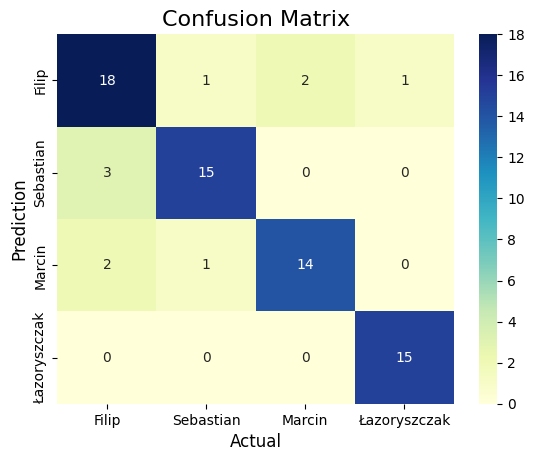

In [32]:
cm = confusion_matrix(y_test, y_pred)
ticks = ["Filip","Sebastian","Marcin","Łazoryszczak"]

sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu',xticklabels=ticks, yticklabels=ticks )
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Random Forest

In [33]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8194444444444444
              precision    recall  f1-score   support

         0.0       0.80      0.73      0.76        22
         1.0       0.94      0.83      0.88        18
         2.0       0.93      0.76      0.84        17
         3.0       0.68      1.00      0.81        15

    accuracy                           0.82        72
   macro avg       0.84      0.83      0.82        72
weighted avg       0.84      0.82      0.82        72



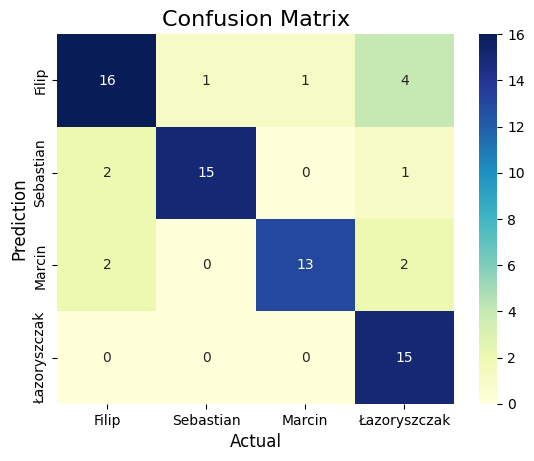

In [34]:
cm = confusion_matrix(y_test, y_pred)
ticks = ["Filip","Sebastian","Marcin","Łazoryszczak"]

sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu',xticklabels=ticks, yticklabels=ticks )
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Multilayer Perceptron

In [35]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(100, 100,100), activation='relu', solver='adam', 
                         max_iter=2000, random_state=42)
mlp_clf.fit(X_train, y_train)
mlp_pred = mlp_clf.predict(X_test)

print("MLP Accuracy:", accuracy_score(y_test, mlp_pred))
print("MLP Classification Report:\n", classification_report(y_test, mlp_pred))

MLP Accuracy: 0.8472222222222222
MLP Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.68      0.77        22
         1.0       0.73      0.89      0.80        18
         2.0       0.94      0.88      0.91        17
         3.0       0.88      1.00      0.94        15

    accuracy                           0.85        72
   macro avg       0.86      0.86      0.85        72
weighted avg       0.86      0.85      0.85        72



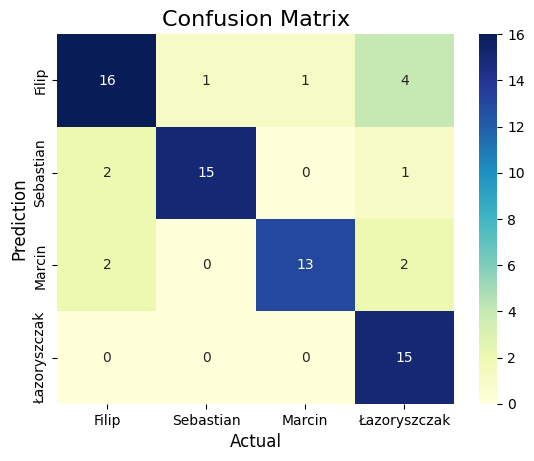

In [36]:
cm = confusion_matrix(y_test, y_pred)
ticks = ["Filip","Sebastian","Marcin","Łazoryszczak"]

sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu',xticklabels=ticks, yticklabels=ticks )
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Spectral Features
### Spectral Centroid, Spectral Bandwidth, Spectral Contrast, Spectral Flatness

In [37]:
spectral_features_no = 4

spectral_features_filip = [i for i in range(no_of_words)]
for i, word in enumerate(words_filip):
    spectral_features_vector = np.zeros(4)
    spectral_features_vector[0] = np.mean(librosa.feature.spectral_centroid(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[1] = np.mean(librosa.feature.spectral_bandwidth(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[2] = np.mean(librosa.feature.spectral_contrast(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[3] = np.mean(librosa.feature.spectral_flatness(y=word),axis=1)[0]
    spectral_features_filip[i] = spectral_features_vector

spectral_features_seb = [i for i in range(no_of_words)]
for i, word in enumerate(words_seb):
    spectral_features_vector = np.zeros(4)
    spectral_features_vector[0] = np.mean(librosa.feature.spectral_centroid(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[1] = np.mean(librosa.feature.spectral_bandwidth(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[2] = np.mean(librosa.feature.spectral_contrast(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[3] = np.mean(librosa.feature.spectral_flatness(y=word),axis=1)[0]
    spectral_features_seb[i] = spectral_features_vector


spectral_features_marcin = [i for i in range(no_of_words)]
for i, word in enumerate(words_marcin):
    spectral_features_vector = np.zeros(4)
    spectral_features_vector[0] = np.mean(librosa.feature.spectral_centroid(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[1] = np.mean(librosa.feature.spectral_bandwidth(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[2] = np.mean(librosa.feature.spectral_contrast(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[3] = np.mean(librosa.feature.spectral_flatness(y=word),axis=1)[0]
    spectral_features_marcin[i] = spectral_features_vector


spectral_features_prof = [i for i in range(no_of_words)]
for i, word in enumerate(words_prof):
    spectral_features_vector = np.zeros(4)
    spectral_features_vector[0] = np.mean(librosa.feature.spectral_centroid(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[1] = np.mean(librosa.feature.spectral_bandwidth(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[2] = np.mean(librosa.feature.spectral_contrast(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[3] = np.mean(librosa.feature.spectral_flatness(y=word),axis=1)[0]
    spectral_features_prof[i] = spectral_features_vector


feature_vector = np.concatenate((spectral_features_filip, spectral_features_seb,spectral_features_marcin,spectral_features_prof))
print(feature_vector.shape)

(120, 4)


# SVM

In [38]:
X_train, X_test, y_train, y_test = train_test_split(feature_vector, labels, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svm = SVC(kernel='rbf', C=1.0, random_state=42)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7833333333333333
              precision    recall  f1-score   support

         0.0       0.83      0.62      0.71        16
         1.0       0.68      0.88      0.77        17
         2.0       0.73      0.73      0.73        15
         3.0       1.00      0.92      0.96        12

    accuracy                           0.78        60
   macro avg       0.81      0.79      0.79        60
weighted avg       0.80      0.78      0.78        60



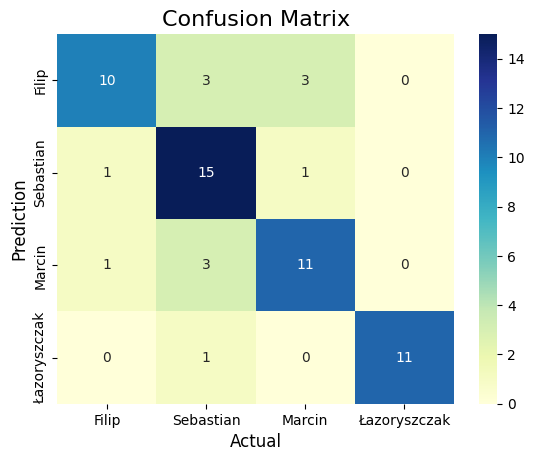

In [39]:
cm = confusion_matrix(y_test, y_pred)
ticks = ["Filip","Sebastian","Marcin","Łazoryszczak"]

sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu',xticklabels=ticks, yticklabels=ticks )
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Random Forest

In [40]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8166666666666667
              precision    recall  f1-score   support

         0.0       0.83      0.62      0.71        16
         1.0       0.75      0.88      0.81        17
         2.0       0.76      0.87      0.81        15
         3.0       1.00      0.92      0.96        12

    accuracy                           0.82        60
   macro avg       0.84      0.82      0.82        60
weighted avg       0.83      0.82      0.81        60



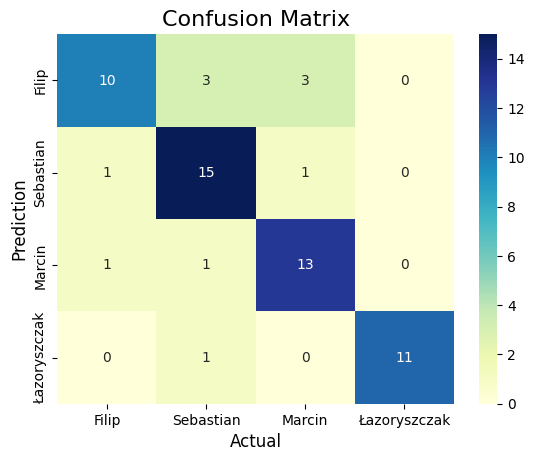

In [41]:
cm = confusion_matrix(y_test, y_pred)
ticks = ["Filip","Sebastian","Marcin","Łazoryszczak"]

sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu',xticklabels=ticks, yticklabels=ticks )
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Multilayer Perceptron

In [42]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,100,100,20), activation='relu', solver='adam', 
                         max_iter=3000, random_state=42)
mlp_clf.fit(X_train, y_train)
mlp_pred = mlp_clf.predict(X_test)

print("MLP Accuracy:", accuracy_score(y_test, mlp_pred))
print("MLP Classification Report:\n", classification_report(y_test, mlp_pred))

MLP Accuracy: 0.8
MLP Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.50      0.64        16
         1.0       0.68      0.88      0.77        17
         2.0       0.78      0.93      0.85        15
         3.0       1.00      0.92      0.96        12

    accuracy                           0.80        60
   macro avg       0.84      0.81      0.80        60
weighted avg       0.82      0.80      0.79        60



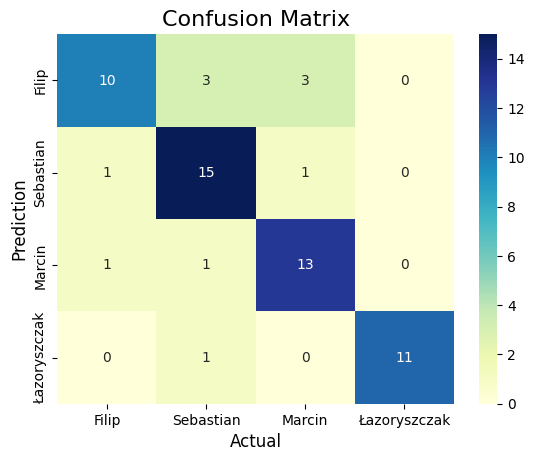

In [43]:
cm = confusion_matrix(y_test, y_pred)
ticks = ["Filip","Sebastian","Marcin","Łazoryszczak"]

sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu',xticklabels=ticks, yticklabels=ticks )
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Zero Crossing Rate

In [44]:
zcr_filip = [i for i in range(no_of_words)]
zcr_seb = [i for i in range(no_of_words)]
zcr_marcin = [i for i in range(no_of_words)]
zcr_prof = [i for i in range(no_of_words)]

for i, word in enumerate(words_filip):
    zcr_filip[i] = librosa.feature.zero_crossing_rate(y=word)[0]

for i, word in enumerate(words_seb):
    zcr_seb[i] = librosa.feature.zero_crossing_rate(y=word)[0]

for i, word in enumerate(words_marcin):
    zcr_marcin[i] = librosa.feature.zero_crossing_rate(y=word)[0]

for i, word in enumerate(words_prof):
    zcr_prof[i] = librosa.feature.zero_crossing_rate(y=word)[0]

#Czyli tamte wyżej są 2D z różną liczbą kolumn

zcr_filip_mean = np.zeros((no_of_words, 1))
zcr_seb_mean = np.zeros((no_of_words, 1))
zcr_marcin_mean = np.zeros((no_of_words, 1))
zcr_prof_mean = np.zeros((no_of_words, 1))

for i in range(no_of_words):
    zcr_filip_mean[i, 0] = np.mean(zcr_filip[i])
    zcr_seb_mean[i, 0] = np.mean(zcr_seb[i])
    zcr_marcin_mean[i, 0] = np.mean(zcr_marcin[i])
    zcr_prof_mean[i, 0] = np.mean(zcr_prof[i])


feature_vector = np.concatenate((zcr_filip_mean, zcr_seb_mean, zcr_marcin_mean, zcr_prof_mean))
print(feature_vector.shape)
labelsF = np.zeros(zcr_filip_mean.shape[0])
labelsS = np.zeros(zcr_seb_mean.shape[0]) + 1
labelsM = np.zeros(zcr_marcin_mean.shape[0]) + 2
labelsP = np.zeros(zcr_prof_mean.shape[0]) + 3

labels = np.concatenate((labelsF, labelsS, labelsM, labelsP))

X_train, X_test, y_train, y_test = train_test_split(feature_vector, labels, test_size=0.5, random_state=44)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

(120, 1)


## SVM

SVM Accuracy: 0.3
              precision    recall  f1-score   support

         0.0       0.25      0.53      0.34        15
         1.0       0.33      0.36      0.34        14
         2.0       0.20      0.12      0.15        16
         3.0       1.00      0.20      0.33        15

    accuracy                           0.30        60
   macro avg       0.45      0.30      0.29        60
weighted avg       0.44      0.30      0.29        60



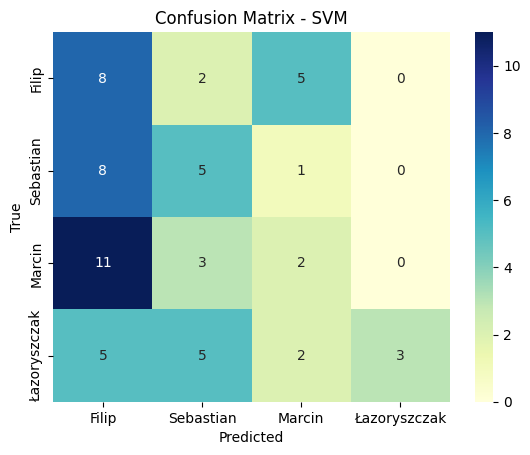

In [45]:
svm = SVC(kernel='rbf', C=1.0, random_state=42)
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, zero_division=1))

cm_svm = confusion_matrix(y_test, y_pred_svm)
ticks = ["Filip", "Sebastian", "Marcin", "Łazoryszczak"]

sns.heatmap(cm_svm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=ticks, yticklabels=ticks)
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Random Forest

Random Forest Accuracy: 0.35
              precision    recall  f1-score   support

         0.0       0.32      0.47      0.38        15
         1.0       0.29      0.14      0.19        14
         2.0       0.36      0.31      0.33        16
         3.0       0.41      0.47      0.44        15

    accuracy                           0.35        60
   macro avg       0.34      0.35      0.33        60
weighted avg       0.34      0.35      0.34        60



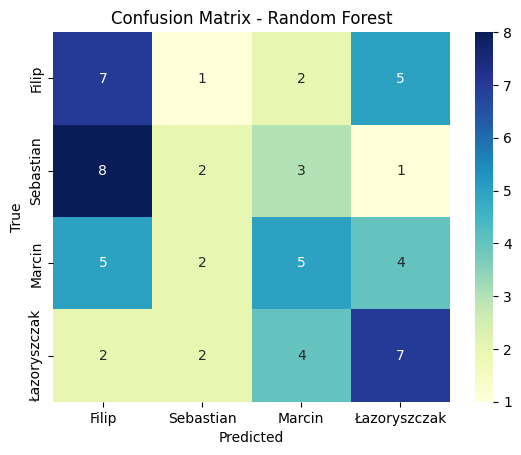

In [46]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, zero_division=1))

cm_rf = confusion_matrix(y_test, y_pred_rf)
ticks = ["Filip", "Sebastian", "Marcin", "Łazoryszczak"]

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='YlGnBu', xticklabels=ticks, yticklabels=ticks)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## MLP

MLP Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

         0.0       0.30      0.40      0.34        15
         1.0       0.38      0.21      0.27        14
         2.0       0.35      0.38      0.36        16
         3.0       0.33      0.33      0.33        15

    accuracy                           0.33        60
   macro avg       0.34      0.33      0.33        60
weighted avg       0.34      0.33      0.33        60



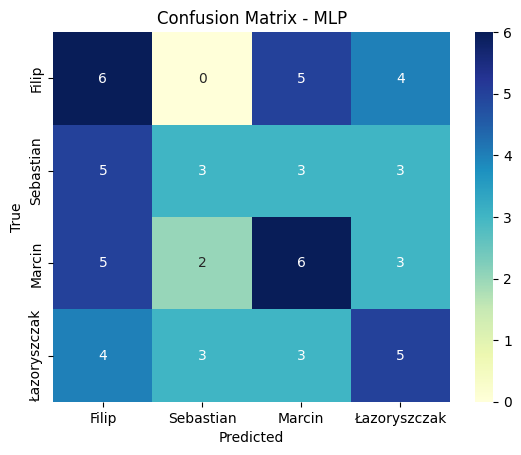

In [47]:
mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=3000, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

print("MLP Accuracy:", accuracy_score(y_test, y_pred_mlp))
print(classification_report(y_test, y_pred_mlp, zero_division=1))

cm_mlp = confusion_matrix(y_test, y_pred_mlp)
ticks = ["Filip", "Sebastian", "Marcin", "Łazoryszczak"]

sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='YlGnBu', xticklabels=ticks, yticklabels=ticks)
plt.title('Confusion Matrix - MLP')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Chroma features

In [48]:
def get_chroma_features(data, chroma_types):
    chroma_stft = []
    chroma_cqt = []
    chroma_cens = []
    chroma_vqt = []


    for audio in data:
        word_stft = chroma_types[list(chroma_types.keys())[0]]["func"](y=audio, sr=sr, **chroma_types[list(chroma_types.keys())[0]]["params"])
        word_cqt = chroma_types[list(chroma_types.keys())[1]]["func"](y=audio, sr=sr, **chroma_types[list(chroma_types.keys())[1]]["params"])
        word_cens = chroma_types[list(chroma_types.keys())[2]]["func"](y=audio, sr=sr, **chroma_types[list(chroma_types.keys())[2]]["params"])
        word_vqt = chroma_types[list(chroma_types.keys())[3]]["func"](y=audio, sr=sr, **chroma_types[list(chroma_types.keys())[3]]["params"])


        chroma_stft.append(word_stft)
        chroma_cqt.append(word_cqt)
        chroma_cens.append(word_cens)
        chroma_vqt.append(word_vqt)

    return chroma_stft, chroma_cqt, chroma_cens, chroma_vqt


def get_mean_chroma_features(data, chroma_types):

    chroma_stft = []
    chroma_cqt = []
    chroma_cens = []
    chroma_vqt = []


    for audio in data:
        word_stft = chroma_types[list(chroma_types.keys())[0]]["func"](y=audio, sr=sr, **chroma_types[list(chroma_types.keys())[0]]["params"])
        word_cqt = chroma_types[list(chroma_types.keys())[1]]["func"](y=audio, sr=sr, **chroma_types[list(chroma_types.keys())[1]]["params"])
        word_cens = chroma_types[list(chroma_types.keys())[2]]["func"](y=audio, sr=sr, **chroma_types[list(chroma_types.keys())[2]]["params"])
        word_vqt = chroma_types[list(chroma_types.keys())[3]]["func"](y=audio, sr=sr, **chroma_types[list(chroma_types.keys())[3]]["params"])


        chroma_stft.append(word_stft.mean(axis=1).flatten())
        chroma_cqt.append(word_cqt.mean(axis=1).flatten())
        chroma_cens.append(word_cens.mean(axis=1).flatten())
        chroma_vqt.append(word_vqt.mean(axis=1).flatten())

    return chroma_stft, chroma_cqt, chroma_cens, chroma_vqt

In [49]:
chroma_types ={
    "stft": {
        "func": librosa.feature.chroma_stft,
        "params": {},
    },
    "cqt": {
        "func": librosa.feature.chroma_cqt,
        "params": {},
    },
    "cens": {
        "func": librosa.feature.chroma_cens,
        "params": {},
    },
    "vqt": {
        "func": librosa.feature.chroma_vqt,
        "params": {"intervals": "equal"},
    }
}

chroma_filip_stft_mean, chroma_filip_cqt_mean, chroma_filip_cens_mean, chroma_filip_vqt_mean = get_mean_chroma_features(words_filip, chroma_types)
chroma_seb_stft_mean, chroma_seb_cqt_mean, chroma_seb_cens_mean, chroma_seb_vqt_mean = get_mean_chroma_features(words_seb, chroma_types)
chroma_marcin_stft_mean, chroma_marcin_cqt_mean, chroma_marcin_cens_mean, chroma_marcin_vqt_mean = get_mean_chroma_features(words_marcin, chroma_types)
chroma_prof_stft_mean, chroma_prof_cqt_mean, chroma_prof_cens_mean, chroma_prof_vqt_mean = get_mean_chroma_features(words_prof, chroma_types)

In [50]:
chroma_filip = np.concatenate((np.array(chroma_filip_stft_mean),np.array(chroma_filip_cqt_mean),np.array(chroma_filip_cens_mean),np.array(chroma_filip_vqt_mean)),axis=1)
chroma_seb = np.concatenate((np.array(chroma_seb_stft_mean),np.array(chroma_seb_cqt_mean),np.array(chroma_seb_cens_mean),np.array(chroma_seb_vqt_mean)),axis=1)
chroma_marcin = np.concatenate((np.array(chroma_marcin_stft_mean),np.array(chroma_marcin_cqt_mean),np.array(chroma_marcin_cens_mean),np.array(chroma_marcin_vqt_mean)),axis=1)
chroma_prof = np.concatenate((np.array(chroma_prof_stft_mean),np.array(chroma_prof_cqt_mean),np.array(chroma_prof_cens_mean),np.array(chroma_prof_vqt_mean)),axis=1)

feature_vector_chroma = np.concatenate((chroma_filip, chroma_seb,chroma_marcin,chroma_prof))
print(feature_vector_chroma.shape)
X_train, X_test, y_train, y_test = train_test_split(feature_vector_chroma, labels, test_size=0.5, random_state=44)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

(120, 48)


# SVM

SVM Accuracy: 0.7833333333333333
              precision    recall  f1-score   support

         0.0       0.77      0.67      0.71        15
         1.0       0.79      0.79      0.79        14
         2.0       0.82      0.88      0.85        16
         3.0       0.75      0.80      0.77        15

    accuracy                           0.78        60
   macro avg       0.78      0.78      0.78        60
weighted avg       0.78      0.78      0.78        60



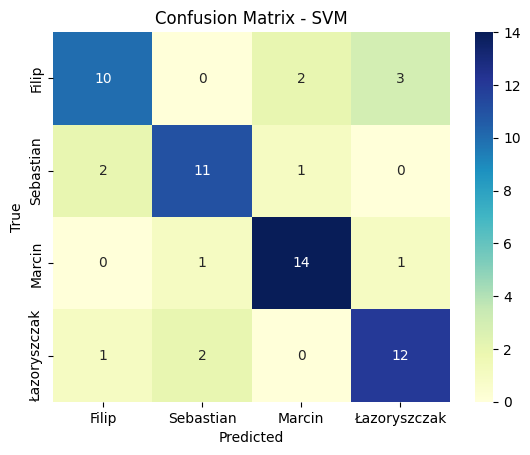

In [51]:
svm = SVC(kernel='rbf', C=1.0, random_state=42)
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, zero_division=1))

cm_svm = confusion_matrix(y_test, y_pred_svm)
ticks = ["Filip", "Sebastian", "Marcin", "Łazoryszczak"]

sns.heatmap(cm_svm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=ticks, yticklabels=ticks)
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Random Forest

Random Forest Accuracy: 0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.80      0.80      0.80        15
         1.0       0.76      0.93      0.84        14
         2.0       0.88      0.88      0.88        16
         3.0       0.92      0.73      0.81        15

    accuracy                           0.83        60
   macro avg       0.84      0.83      0.83        60
weighted avg       0.84      0.83      0.83        60



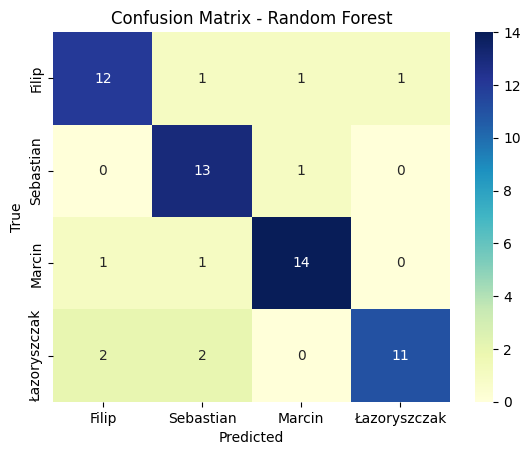

In [52]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, zero_division=1))

cm_rf = confusion_matrix(y_test, y_pred_rf)
ticks = ["Filip", "Sebastian", "Marcin", "Łazoryszczak"]

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='YlGnBu', xticklabels=ticks, yticklabels=ticks)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## MLP

MLP Accuracy: 0.8
              precision    recall  f1-score   support

         0.0       0.83      0.67      0.74        15
         1.0       0.75      0.86      0.80        14
         2.0       0.88      0.88      0.88        16
         3.0       0.75      0.80      0.77        15

    accuracy                           0.80        60
   macro avg       0.80      0.80      0.80        60
weighted avg       0.80      0.80      0.80        60



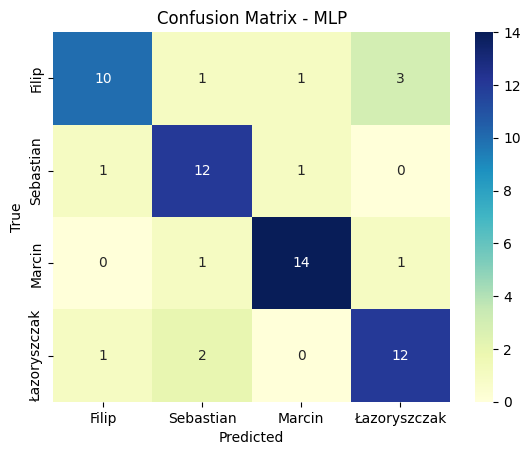

In [53]:
mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=3000, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

print("MLP Accuracy:", accuracy_score(y_test, y_pred_mlp))
print(classification_report(y_test, y_pred_mlp, zero_division=1))

cm_mlp = confusion_matrix(y_test, y_pred_mlp)
ticks = ["Filip", "Sebastian", "Marcin", "Łazoryszczak"]

sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='YlGnBu', xticklabels=ticks, yticklabels=ticks)
plt.title('Confusion Matrix - MLP')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Feature Select
## Do wybrania najelpszeych cech użyto SelectKBest - wybranie najlepszych k cech na podstawie danego krytetrium

In [54]:
#Funckja do spłaszczania tablicy 3d do 2d. Robi flatten na ostatnich dwóch wymiarach
def flatten_features(data,X,Y,Z):

    mfcc_cut = np.zeros((X,Y,Z))
    mfcc_final = np.zeros((X,Y*Z))

    for i in range(X):
        for j in range(Y):
            mfcc_cut[i][j] =  data[i][j][:Z]

        to_flatten =  mfcc_cut[i]
        mfcc_final[i] = to_flatten.flatten()
    return mfcc_final

labelsF = np.zeros(mfcc_filip_mean.shape[0])
labelsS = np.zeros(mfcc_filip_mean.shape[0])+1
labelsM = np.zeros(mfcc_filip_mean.shape[0])+2
labelsL = np.zeros(mfcc_filip_mean.shape[0])+3
labels_names = np.concatenate((labelsF, labelsS,labelsM,labelsL))

## MFCC

In [55]:
mfcc_features_no = 13
mfcc_filip = [i for i in range(no_of_words)]
mfcc_delta_filip = [i for i in range(no_of_words)]
mfcc_delta2_filip = [i for i in range(no_of_words)]
for i, word in enumerate(words_filip):
    mfcc_filip[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
    mfcc_delta_filip[i] = librosa.feature.delta(mfcc_filip[i])
    mfcc_delta2_filip[i] =  librosa.feature.delta(mfcc_filip[i], order=2)


mfcc_seb = [i for i in range(no_of_words)]
mfcc_delta_seb = [i for i in range(no_of_words)]
mfcc_delta2_seb = [i for i in range(no_of_words)]
for i, word in enumerate(words_seb):
    mfcc_seb[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
    mfcc_delta_seb[i] = librosa.feature.delta(mfcc_seb[i])
    mfcc_delta2_seb[i] =  librosa.feature.delta(mfcc_seb[i], order=2)

mfcc_marcin = [i for i in range(no_of_words)]
mfcc_delta_marcin = [i for i in range(no_of_words)]
mfcc_delta2_marcin = [i for i in range(no_of_words)]
for i, word in enumerate(words_marcin):
    mfcc_marcin[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
    mfcc_delta_marcin[i] = librosa.feature.delta(mfcc_marcin[i])
    mfcc_delta2_marcin[i] =  librosa.feature.delta(mfcc_marcin[i], order=2)


mfcc_prof = [i for i in range(no_of_words)]
mfcc_delta_prof = [i for i in range(no_of_words)]
mfcc_delta2_prof = [i for i in range(no_of_words)]
for i, word in enumerate(words_prof):
    mfcc_prof[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
    mfcc_delta_prof[i] = librosa.feature.delta(mfcc_prof[i])
    mfcc_delta2_prof[i] =  librosa.feature.delta(mfcc_prof[i], order=2)

# Macierze mfcc mają wymiar (30,13,x), gdzie x ma różną długość dla każdego słowwa.
# Może obciąż wszystkie dla najmniejszej długości
# to może ograniczyć i zrobić flatten
least_to_take = 50

mfcc_filip_final = flatten_features(mfcc_filip, no_of_words, mfcc_features_no,least_to_take)
mfcc_seb_final = flatten_features(mfcc_seb, no_of_words, mfcc_features_no,least_to_take)
mfcc_marcin_final = flatten_features(mfcc_marcin, no_of_words, mfcc_features_no,least_to_take)
mfcc_prof_final = flatten_features(mfcc_prof, no_of_words, mfcc_features_no,least_to_take)


mfcc_delta_filip_final = flatten_features(mfcc_delta_filip, no_of_words, mfcc_features_no,least_to_take)
mfcc_delta_seb_final = flatten_features(mfcc_delta_seb, no_of_words, mfcc_features_no,least_to_take)
mfcc_delta_marcin_final = flatten_features(mfcc_delta_marcin, no_of_words, mfcc_features_no,least_to_take)
mfcc_delta_prof_final = flatten_features(mfcc_delta_prof, no_of_words, mfcc_features_no,least_to_take)

mfcc_delta2_filip_final = flatten_features(mfcc_delta2_filip, no_of_words, mfcc_features_no,least_to_take)
mfcc_delta2_seb_final = flatten_features(mfcc_delta2_seb, no_of_words, mfcc_features_no,least_to_take)
mfcc_delta2_marcin_final = flatten_features(mfcc_delta2_marcin, no_of_words, mfcc_features_no,least_to_take)
mfcc_delta2_prof_final = flatten_features(mfcc_delta2_prof, no_of_words, mfcc_features_no,least_to_take)






feature_vector_mfcc = np.concatenate((mfcc_filip_final, mfcc_seb_final,mfcc_marcin_final,mfcc_prof_final))
feature_vector_mfcc_delta = np.concatenate((mfcc_delta_filip_final, mfcc_delta_seb_final,mfcc_delta_marcin_final,mfcc_delta_prof_final))
feature_vector_mfcc_delta2 = np.concatenate((mfcc_delta2_filip_final, mfcc_delta2_seb_final,mfcc_delta2_marcin_final,mfcc_delta2_prof_final))

feature_vector_mfcc = np.concatenate((feature_vector_mfcc, feature_vector_mfcc_delta,feature_vector_mfcc_delta2), axis=1)
print(feature_vector_mfcc.shape)

(120, 1950)


## Przykład użycia SelectKBest

In [56]:
def get_bar_plot(data, labels, title):
    plt.bar(labels, data)
    plt.title(title)
    plt.xlabel('number of features')
    plt.ylabel('Accuracy')
    plt.show()

# SVM 

[0.5, 0.5416666666666666, 0.75, 0.8333333333333334, 0.7916666666666666, 0.7916666666666666, 0.7916666666666666, 0.7083333333333334]


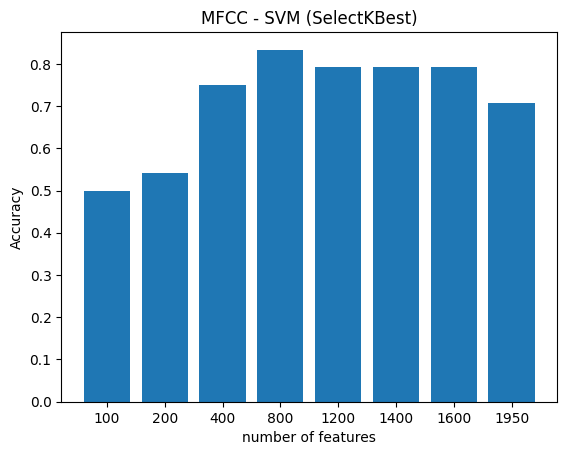

In [57]:
X_train, X_test, y_train, y_test = train_test_split(feature_vector_mfcc, labels_names, test_size=0.2, random_state=42)
#jest 1950 cech
#Jest 500 cech w sumie
how_many_features = [100, 200, 400, 800, 1200, 1400, 1600, 1950]
accuracies_mfcc = []


for how_many in how_many_features:
    selector = SelectKBest(score_func=f_classif, k=how_many)  
    X_train_selected = selector.fit_transform(X_train, y_train)  
    X_test_selected = selector.transform(X_test)  

    scaler = StandardScaler()
    X_train_selected = scaler.fit_transform(X_train_selected)
    X_test_selected = scaler.transform(X_test_selected)


    svm = SVC(kernel='sigmoid', C=1.0, random_state=42)
    svm.fit(X_train_selected, y_train)
    y_pred = svm.predict(X_test_selected)
    accuracies_mfcc.append(accuracy_score(y_test, y_pred))
print(accuracies_mfcc)
labels = [str(i) for i in how_many_features]
get_bar_plot(accuracies_mfcc, labels, "MFCC - SVM (SelectKBest)")

## Random Forest

[0.625, 0.5833333333333334, 0.6666666666666666, 0.6666666666666666, 0.7083333333333334, 0.75, 0.7916666666666666, 0.8333333333333334]


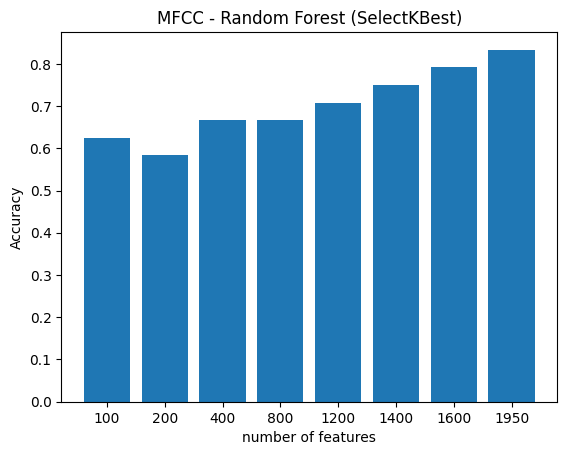

In [58]:

accuracies_mfcc = []

for how_many in how_many_features:
    selector = SelectKBest(score_func=f_classif, k=how_many)  
    X_train_selected = selector.fit_transform(X_train, y_train)  
    X_test_selected = selector.transform(X_test)  

    scaler = StandardScaler()
    X_train_selected = scaler.fit_transform(X_train_selected)
    X_test_selected = scaler.transform(X_test_selected)


    rbf = RandomForestClassifier(n_estimators=100, random_state=42)
    rbf.fit(X_train_selected, y_train)
    y_pred = rbf.predict(X_test_selected)
    accuracies_mfcc.append(accuracy_score(y_test, y_pred))
    
print(accuracies_mfcc)
labels = [str(i) for i in how_many_features]
get_bar_plot(accuracies_mfcc, labels, "MFCC - Random Forest (SelectKBest)")

## MLP

[0.5833333333333334, 0.625, 0.75, 0.7916666666666666, 0.8333333333333334, 0.75, 0.8333333333333334, 0.75]


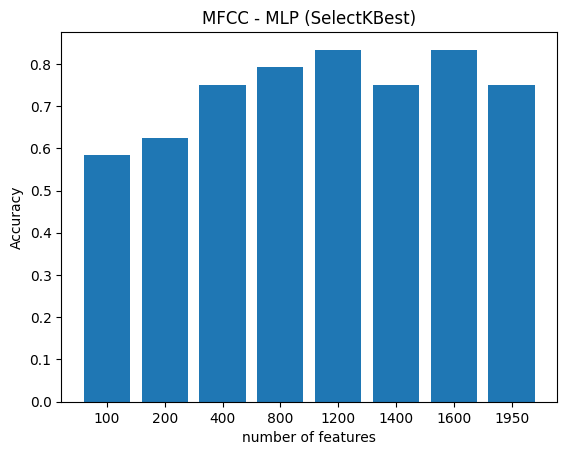

In [59]:
how_many_features = [100, 200, 400, 800, 1200, 1400, 1600, 1950]
accuracies_mfcc = []


for how_many in how_many_features:
    selector = SelectKBest(score_func=f_classif, k=how_many)  
    X_train_selected = selector.fit_transform(X_train, y_train)  
    X_test_selected = selector.transform(X_test)  

    scaler = StandardScaler()
    X_train_selected = scaler.fit_transform(X_train_selected)
    X_test_selected = scaler.transform(X_test_selected)


    mlp_clf = MLPClassifier(hidden_layer_sizes=(100, 100,100), activation='relu', solver='adam', 
                         max_iter=2000, random_state=42)
    mlp_clf.fit(X_train_selected, y_train)
    y_pred = mlp_clf.predict(X_test_selected)
    accuracies_mfcc.append(accuracy_score(y_test, y_pred))
print(accuracies_mfcc)
labels = [str(i) for i in how_many_features]
get_bar_plot(accuracies_mfcc, labels, "MFCC - MLP (SelectKBest)")

# Spectral

In [60]:
spectral_features_no = 4

spectral_features_filip = [i for i in range(no_of_words)]
for i, word in enumerate(words_filip):
    spectral_features_vector = [0]*10
    spectral_features_vector[0] = librosa.feature.spectral_centroid(y=word, sr=sr)[0]
    spectral_features_vector[1] = librosa.feature.spectral_bandwidth(y=word, sr=sr)[0]
    for j in range(2,9):
        spectral_features_vector[j] = librosa.feature.spectral_contrast(y=word, sr=sr)[j-3]
    spectral_features_vector[9] = librosa.feature.spectral_flatness(y=word)[0]
    spectral_features_filip[i] = spectral_features_vector

spectral_features_seb = [i for i in range(no_of_words)]
for i, word in enumerate(words_seb):
    spectral_features_vector = [0]*10
    spectral_features_vector[0] = librosa.feature.spectral_centroid(y=word, sr=sr)[0]
    spectral_features_vector[1] = librosa.feature.spectral_bandwidth(y=word, sr=sr)[0]
    for j in range(2,9):
        spectral_features_vector[j] = librosa.feature.spectral_contrast(y=word, sr=sr)[j-3]
    spectral_features_vector[9] = librosa.feature.spectral_flatness(y=word)[0]
    spectral_features_seb[i] = spectral_features_vector


spectral_features_marcin = [i for i in range(no_of_words)]
for i, word in enumerate(words_marcin):
    spectral_features_vector = [0]*10
    spectral_features_vector[0] = librosa.feature.spectral_centroid(y=word, sr=sr)[0]
    spectral_features_vector[1] = librosa.feature.spectral_bandwidth(y=word, sr=sr)[0]
    for j in range(2,9):
        spectral_features_vector[j] = librosa.feature.spectral_contrast(y=word, sr=sr)[j-3]
    spectral_features_vector[9] = librosa.feature.spectral_flatness(y=word)[0]
    spectral_features_marcin[i] = spectral_features_vector

spectral_features_prof= [i for i in range(no_of_words)]
for i, word in enumerate(words_prof):
    spectral_features_vector = [0]*10
    spectral_features_vector[0] = librosa.feature.spectral_centroid(y=word, sr=sr)[0]
    spectral_features_vector[1] = librosa.feature.spectral_bandwidth(y=word, sr=sr)[0]
    for j in range(2,9):
        spectral_features_vector[j] = librosa.feature.spectral_contrast(y=word, sr=sr)[j-3]
    spectral_features_vector[9] = librosa.feature.spectral_flatness(y=word)[0]
    spectral_features_prof[i] = spectral_features_vector


least_to_take = 50

spectral_filip_final = flatten_features(spectral_features_filip, no_of_words, 10, least_to_take)
spectral_seb_final = flatten_features(spectral_features_seb, no_of_words, 10, least_to_take)
spectral_marcin_final = flatten_features(spectral_features_marcin, no_of_words, 10, least_to_take)
spectral_prof_final = flatten_features(spectral_features_prof, no_of_words, 10, least_to_take)

feature_vector_spec = np.concatenate((spectral_filip_final, spectral_seb_final,spectral_marcin_final,spectral_prof_final))
print(feature_vector_spec.shape)

(120, 500)


## SVM

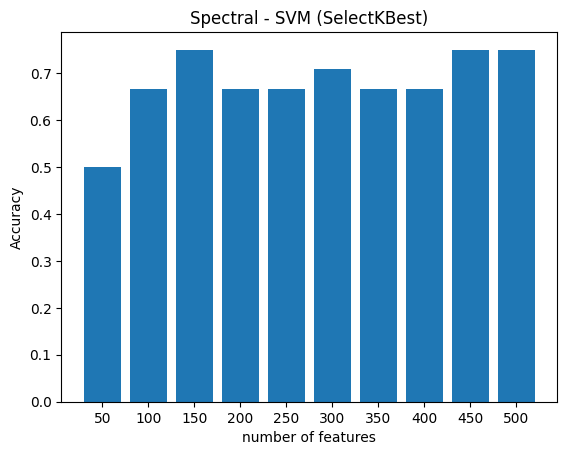

In [61]:
X_train, X_test, y_train, y_test = train_test_split(feature_vector_spec, labels_names, test_size=0.2, random_state=42)
#jest 500 
how_many_features = [50,100,150,200,250,300,350,400,450,500]
accuracies_spectral = []
for how_many in how_many_features:
    selector = SelectKBest(score_func=f_classif, k=how_many)  
    X_train_selected = selector.fit_transform(X_train, y_train)  
    X_test_selected = selector.transform(X_test)  

    scaler = StandardScaler()
    X_train_selected = scaler.fit_transform(X_train_selected)
    X_test_selected = scaler.transform(X_test_selected)

    svm = SVC(kernel='sigmoid', C=1.0, random_state=42)
    svm.fit(X_train_selected, y_train)
    y_pred = svm.predict(X_test_selected)
    accuracies_spectral.append(accuracy_score(y_test, y_pred))

labels = [str(i) for i in how_many_features]
get_bar_plot(accuracies_spectral, labels, "Spectral - SVM (SelectKBest)")
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print(classification_report(y_test, y_pred))

## Random Forest

[0.75, 0.75, 0.7916666666666666, 0.75, 0.7083333333333334, 0.7916666666666666, 0.75, 0.7916666666666666, 0.7083333333333334, 0.75]


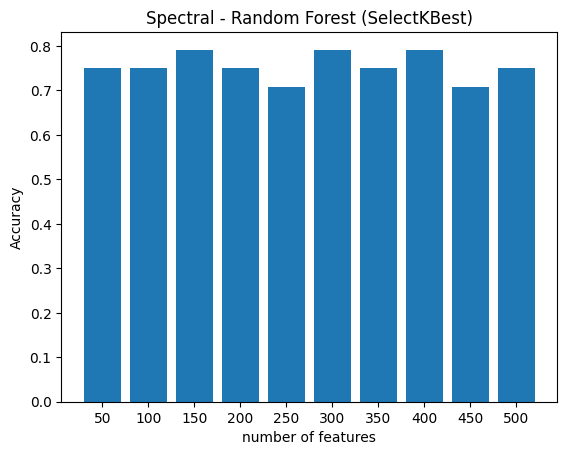

In [62]:
accuracies_spectral = []

for how_many in how_many_features:
    selector = SelectKBest(score_func=f_classif, k=how_many)  
    X_train_selected = selector.fit_transform(X_train, y_train)  
    X_test_selected = selector.transform(X_test)  

    scaler = StandardScaler()
    X_train_selected = scaler.fit_transform(X_train_selected)
    X_test_selected = scaler.transform(X_test_selected)


    rbf = RandomForestClassifier(n_estimators=100, random_state=42)
    rbf.fit(X_train_selected, y_train)
    y_pred = rbf.predict(X_test_selected)
    accuracies_spectral.append(accuracy_score(y_test, y_pred))
    
print(accuracies_spectral)
labels = [str(i) for i in how_many_features]
get_bar_plot(accuracies_spectral, labels, "Spectral - Random Forest (SelectKBest)")

## MLP

[0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.75, 0.7083333333333334, 0.7083333333333334, 0.7083333333333334]


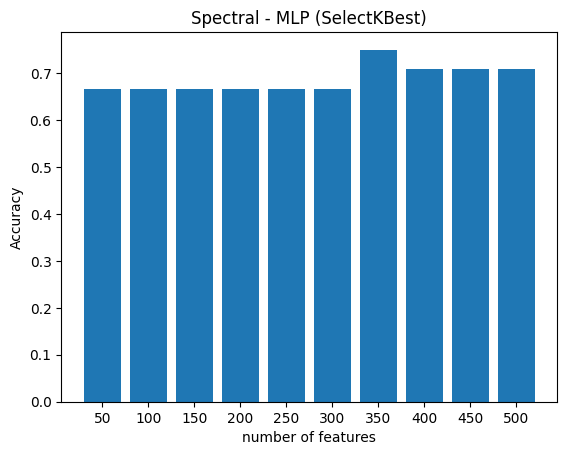

In [63]:
accuracies_spectral = []


for how_many in how_many_features:
    selector = SelectKBest(score_func=f_classif, k=how_many)  
    X_train_selected = selector.fit_transform(X_train, y_train)  
    X_test_selected = selector.transform(X_test)  

    scaler = StandardScaler()
    X_train_selected = scaler.fit_transform(X_train_selected)
    X_test_selected = scaler.transform(X_test_selected)


    mlp_clf = MLPClassifier(hidden_layer_sizes=(100, 100,100), activation='relu', solver='adam', 
                         max_iter=2000, random_state=42)
    mlp_clf.fit(X_train_selected, y_train)
    y_pred = mlp_clf.predict(X_test_selected)
    accuracies_spectral.append(accuracy_score(y_test, y_pred))
print(accuracies_spectral)
labels = [str(i) for i in how_many_features]
get_bar_plot(accuracies_spectral, labels, "Spectral - MLP (SelectKBest)")

# Zero crossing rate

In [64]:

to_take = 50
for i in range(len(zcr_filip)):
    zcr_filip[i] = zcr_filip[i][:to_take]
    zcr_seb[i] = zcr_seb[i][:to_take]
    zcr_marcin[i] = zcr_marcin[i][:to_take]
    zcr_prof[i] = zcr_prof[i][:to_take]

zcr_filip = np.array(zcr_filip)
zcr_seb = np.array(zcr_seb)
zcr_marcin = np.array(zcr_marcin)
zcr_prof = np.array(zcr_prof)

feature_vector_zeros = np.concatenate((zcr_filip, zcr_seb,zcr_marcin,zcr_prof))
print(feature_vector_zeros.shape)

(120, 50)


### SVM

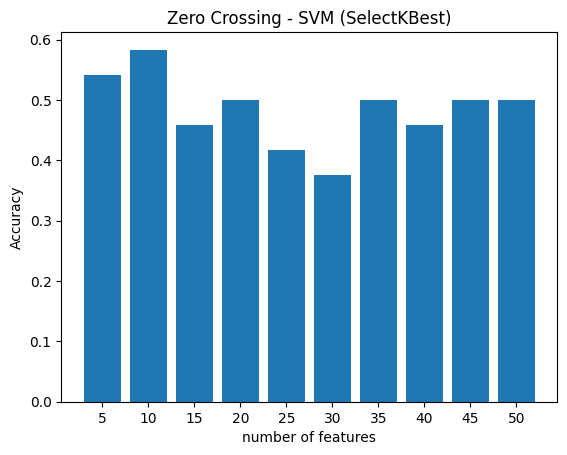

In [65]:
X_train, X_test, y_train, y_test = train_test_split(feature_vector_zeros, labels_names, test_size=0.2, random_state=42)
how_many_features = [5,10,15,20,25,30,35,40,45,50]
accuracies_zcr = []
for how_many in how_many_features:
    selector = SelectKBest(score_func=f_classif, k=how_many)  
    X_train_selected = selector.fit_transform(X_train, y_train)  
    X_test_selected = selector.transform(X_test)  

    scaler = StandardScaler()
    X_train_selected = scaler.fit_transform(X_train_selected)
    X_test_selected = scaler.transform(X_test_selected)

    svm = SVC(kernel='sigmoid', C=1.0, random_state=42)
    svm.fit(X_train_selected, y_train)
    y_pred = svm.predict(X_test_selected)
    accuracies_zcr.append(accuracy_score(y_test, y_pred))

# print("Accuracy:", accuracy_score(y_test, y_pred))
# print(classification_report(y_test, y_pred))
labels = [str(i) for i in how_many_features]
get_bar_plot(accuracies_zcr, labels, "Zero Crossing - SVM (SelectKBest)")

## Random Forest

[0.5416666666666666, 0.7083333333333334, 0.6666666666666666, 0.625, 0.6666666666666666, 0.625, 0.6666666666666666, 0.6666666666666666, 0.5416666666666666, 0.5416666666666666]


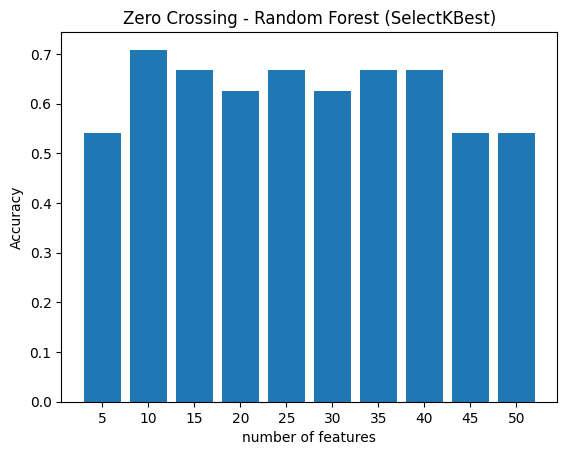

In [66]:
accuracies_zcr = []

for how_many in how_many_features:
    selector = SelectKBest(score_func=f_classif, k=how_many)  
    X_train_selected = selector.fit_transform(X_train, y_train)  
    X_test_selected = selector.transform(X_test)  

    scaler = StandardScaler()
    X_train_selected = scaler.fit_transform(X_train_selected)
    X_test_selected = scaler.transform(X_test_selected)


    rbf = RandomForestClassifier(n_estimators=100, random_state=42)
    rbf.fit(X_train_selected, y_train)
    y_pred = rbf.predict(X_test_selected)
    accuracies_zcr.append(accuracy_score(y_test, y_pred))
    
print(accuracies_zcr)
labels = [str(i) for i in how_many_features]
get_bar_plot(accuracies_zcr, labels, "Zero Crossing - Random Forest (SelectKBest)")

## MLP

[0.5416666666666666, 0.5416666666666666, 0.6666666666666666, 0.75, 0.7083333333333334, 0.625, 0.6666666666666666, 0.5833333333333334, 0.5833333333333334, 0.5]


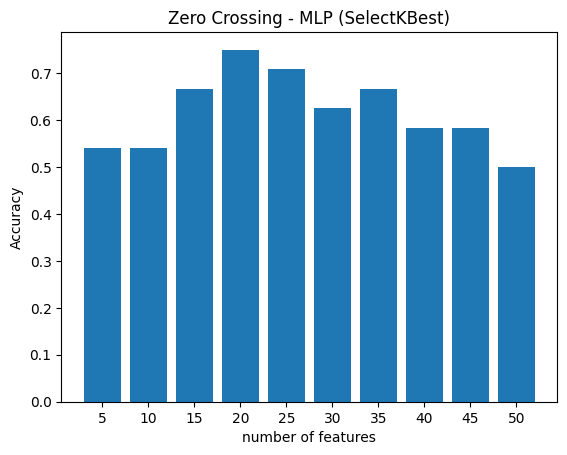

In [67]:
accuracies_zcr = []


for how_many in how_many_features:
    selector = SelectKBest(score_func=f_classif, k=how_many)  
    X_train_selected = selector.fit_transform(X_train, y_train)  
    X_test_selected = selector.transform(X_test)  

    scaler = StandardScaler()
    X_train_selected = scaler.fit_transform(X_train_selected)
    X_test_selected = scaler.transform(X_test_selected)


    mlp_clf = MLPClassifier(hidden_layer_sizes=(100, 100,100), activation='relu', solver='adam', 
                         max_iter=2000, random_state=42)
    mlp_clf.fit(X_train_selected, y_train)
    y_pred = mlp_clf.predict(X_test_selected)
    accuracies_zcr.append(accuracy_score(y_test, y_pred))
print(accuracies_zcr)
labels = [str(i) for i in how_many_features]
get_bar_plot(accuracies_zcr, labels, "Zero Crossing - MLP (SelectKBest)")

# Chroma 

In [68]:
chroma_filip_stft, chroma_filip_cqt, chroma_filip_cens, chroma_filip_vqt = get_chroma_features(words_filip, chroma_types)
chroma_seb_stft, chroma_seb_cqt, chroma_seb_cens, chroma_seb_vqt = get_chroma_features(words_seb, chroma_types)
chroma_marcin_stft, chroma_marcin_cqt, chroma_marcin_cens, chroma_marcin_vqt = get_chroma_features(words_marcin, chroma_types)
chroma_prof_stft, chroma_prof_cqt, chroma_prof_cens, chroma_prof_vqt = get_chroma_features(words_prof, chroma_types)



In [69]:
least_to_take = 50

chroma_filip_stft_final = flatten_features(chroma_filip_stft, no_of_words, 12, least_to_take)
chroma_filip_cqt_final  = flatten_features(chroma_filip_cqt, no_of_words, 12, least_to_take)
chroma_filip_cens_final  = flatten_features(chroma_filip_cens, no_of_words, 12, least_to_take)
chroma_filip_vqt_final  = flatten_features(chroma_filip_vqt, no_of_words, 12, least_to_take)

chroma_filip_final = np.concatenate((chroma_filip_stft_final, chroma_filip_cqt_final,chroma_filip_cens_final,chroma_filip_vqt_final),axis=1)

chroma_seb_stft_final = flatten_features(chroma_seb_stft, no_of_words, 12, least_to_take)
chroma_seb_cqt_final  = flatten_features(chroma_seb_cqt, no_of_words, 12, least_to_take)
chroma_seb_cens_final  = flatten_features(chroma_seb_cens, no_of_words, 12, least_to_take)
chroma_seb_vqt_final  = flatten_features(chroma_seb_vqt, no_of_words, 12, least_to_take)

chroma_seb_final = np.concatenate((chroma_seb_stft_final, chroma_seb_cqt_final,chroma_seb_cens_final,chroma_seb_vqt_final),axis=1)

chroma_marcin_stft_final = flatten_features(chroma_marcin_stft, no_of_words, 12, least_to_take)
chroma_marcin_cqt_final  = flatten_features(chroma_marcin_cqt, no_of_words, 12, least_to_take)
chroma_marcin_cens_final  = flatten_features(chroma_marcin_cens, no_of_words, 12, least_to_take)
chroma_marcin_vqt_final  = flatten_features(chroma_marcin_vqt, no_of_words, 12, least_to_take)

chroma_marcin_final = np.concatenate((chroma_marcin_stft_final, chroma_marcin_cqt_final,chroma_marcin_cens_final,chroma_marcin_vqt_final),axis=1)

chroma_prof_stft_final = flatten_features(chroma_prof_stft, no_of_words, 12, least_to_take)
chroma_prof_cqt_final  = flatten_features(chroma_prof_cqt, no_of_words, 12, least_to_take)
chroma_prof_cens_final  = flatten_features(chroma_prof_cens, no_of_words, 12, least_to_take)
chroma_prof_vqt_final  = flatten_features(chroma_prof_vqt, no_of_words, 12, least_to_take)

chroma_prof_final = np.concatenate((chroma_prof_stft_final, chroma_prof_cqt_final,chroma_prof_cens_final,chroma_prof_vqt_final),axis=1)


feature_vector_chroma = np.concatenate((chroma_filip_final, chroma_seb_final,chroma_marcin_final,chroma_prof_final))
print(feature_vector_chroma.shape)

(120, 2400)


## SVM

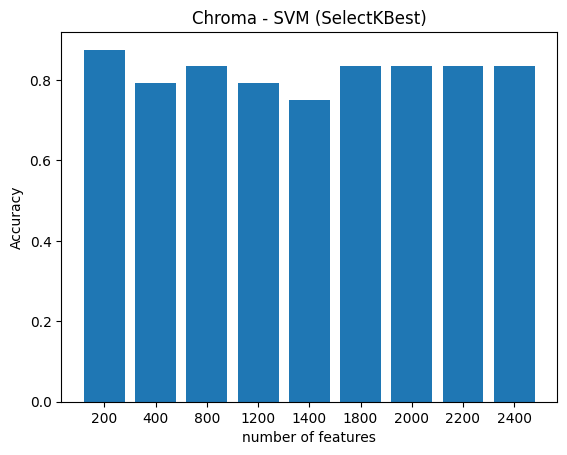

In [70]:
X_train, X_test, y_train, y_test = train_test_split(feature_vector_chroma, labels_names, test_size=0.2, random_state=42)
# Jest 2400 cech
how_many_features = [200,400,800,1200,1400,1800,2000,2200,2400]

accuracies_chroma = []
for how_many in how_many_features:
    selector = SelectKBest(score_func=f_classif, k=how_many)  
    X_train_selected = selector.fit_transform(X_train, y_train)  
    X_test_selected = selector.transform(X_test)  

    scaler = StandardScaler()
    X_train_selected = scaler.fit_transform(X_train_selected)
    X_test_selected = scaler.transform(X_test_selected)

    svm = SVC(kernel='sigmoid', C=1.0, random_state=42)
    svm.fit(X_train_selected, y_train)
    y_pred = svm.predict(X_test_selected)
    accuracies_chroma.append(accuracy_score(y_test, y_pred))

labels = [str(i) for i in how_many_features]
get_bar_plot(accuracies_chroma, labels, "Chroma - SVM (SelectKBest)")
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print(classification_report(y_test, y_pred))

## Random Forest

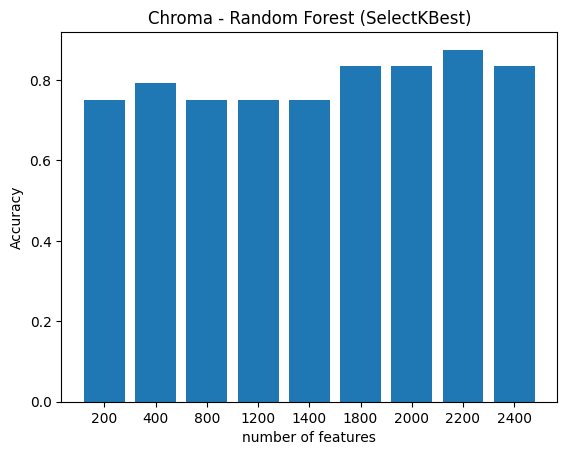

In [71]:
accuracies_chroma = []
for how_many in how_many_features:
    selector = SelectKBest(score_func=f_classif, k=how_many)  
    X_train_selected = selector.fit_transform(X_train, y_train)  
    X_test_selected = selector.transform(X_test)  

    scaler = StandardScaler()
    X_train_selected = scaler.fit_transform(X_train_selected)
    X_test_selected = scaler.transform(X_test_selected)

    rbf = RandomForestClassifier(n_estimators=100, random_state=42)
    rbf.fit(X_train_selected, y_train)
    y_pred = rbf.predict(X_test_selected)
    accuracies_chroma.append(accuracy_score(y_test, y_pred))

labels = [str(i) for i in how_many_features]
get_bar_plot(accuracies_chroma, labels, "Chroma - Random Forest (SelectKBest)")

## MLP

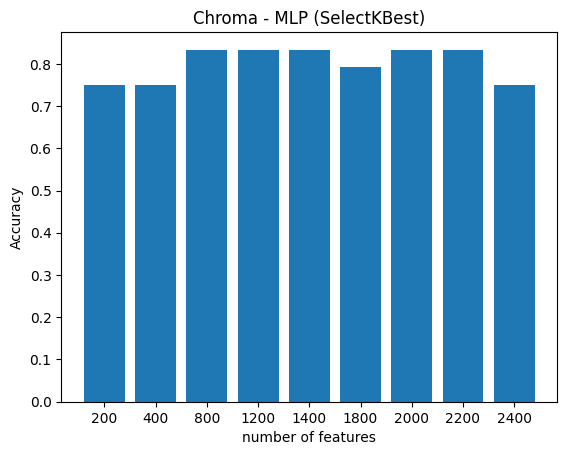

In [72]:
accuracies_chroma = []
for how_many in how_many_features:
    selector = SelectKBest(score_func=f_classif, k=how_many)  
    X_train_selected = selector.fit_transform(X_train, y_train)  
    X_test_selected = selector.transform(X_test)  

    scaler = StandardScaler()
    X_train_selected = scaler.fit_transform(X_train_selected)
    X_test_selected = scaler.transform(X_test_selected)

    mlp_clf = MLPClassifier(hidden_layer_sizes=(100, 100,100), activation='relu', solver='adam', 
                         max_iter=2000, random_state=42)
    mlp_clf.fit(X_train_selected, y_train)

    y_pred = mlp_clf.predict(X_test_selected)
    accuracies_chroma.append(accuracy_score(y_test, y_pred))
labels = [str(i) for i in how_many_features]
get_bar_plot(accuracies_chroma, labels, "Chroma - MLP (SelectKBest)")

## Połączenie MFCC i Spectral i zero crossing i chroma

## SVM

(120, 4900)


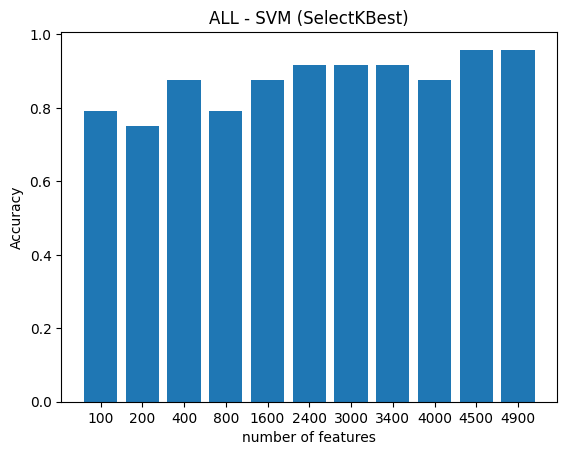

In [73]:

feature_vector = np.concatenate((feature_vector_mfcc, feature_vector_spec,feature_vector_zeros,feature_vector_chroma), axis=1)
print(feature_vector.shape)
# W sumie 4900 featerów
how_many_features = [100,200,400,800,1600,2400,3000,3400,4000,4500, 4900]



accuracies = []
X_train, X_test, y_train, y_test = train_test_split(feature_vector, labels_names, test_size=0.2, random_state=42)
for how_many in how_many_features:
    selector = SelectKBest(score_func=f_classif, k=how_many)  
    X_train_selected = selector.fit_transform(X_train, y_train)  
    X_test_selected = selector.transform(X_test)  

    scaler = StandardScaler()
    X_train_selected = scaler.fit_transform(X_train_selected)
    X_test_selected = scaler.transform(X_test_selected)

    svm = SVC(kernel='linear', C=1.0, random_state=42)
    svm.fit(X_train_selected, y_train)
    y_pred = svm.predict(X_test_selected)
    accuracies.append(accuracy_score(y_test, y_pred))
    
labels = [str(i) for i in how_many_features]
get_bar_plot(accuracies, labels, "ALL - SVM (SelectKBest)")
# print("Accuracy:", accuracy_score(y_test, y_pred))
print(accuracies)

## Random Forest

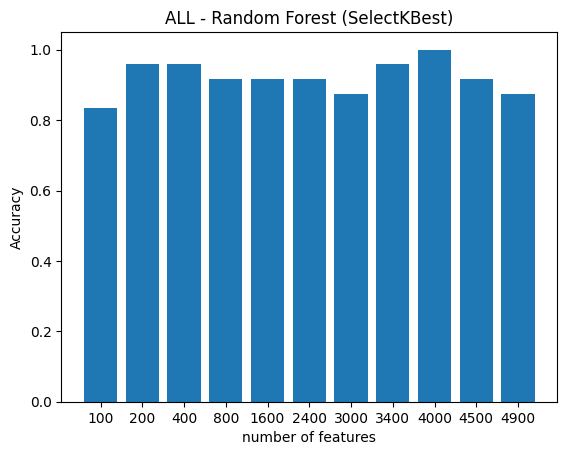

In [74]:
accuracies = []
for how_many in how_many_features:
    selector = SelectKBest(score_func=f_classif, k=how_many)  
    X_train_selected = selector.fit_transform(X_train, y_train)  
    X_test_selected = selector.transform(X_test)  

    scaler = StandardScaler()
    X_train_selected = scaler.fit_transform(X_train_selected)
    X_test_selected = scaler.transform(X_test_selected)

    rbf = RandomForestClassifier(n_estimators=100, random_state=42)
    rbf.fit(X_train_selected, y_train)
    y_pred = rbf.predict(X_test_selected)
    accuracies.append(accuracy_score(y_test, y_pred))

labels = [str(i) for i in how_many_features]
get_bar_plot(accuracies, labels, "ALL - Random Forest (SelectKBest)")
print(accuracies)

## MLP

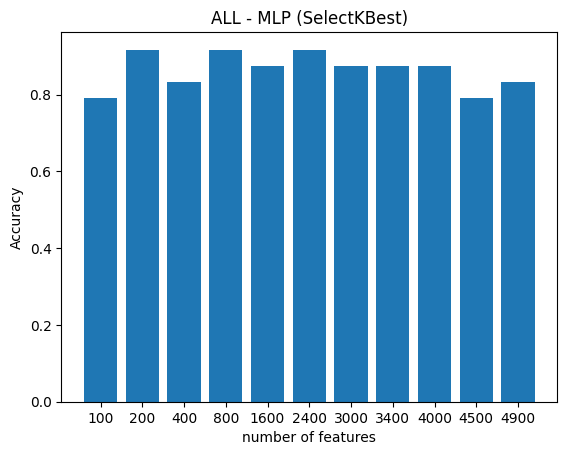

In [75]:
accuracies = []
for how_many in how_many_features:
    selector = SelectKBest(score_func=f_classif, k=how_many)  
    X_train_selected = selector.fit_transform(X_train, y_train)  
    X_test_selected = selector.transform(X_test)  

    scaler = StandardScaler()
    X_train_selected = scaler.fit_transform(X_train_selected)
    X_test_selected = scaler.transform(X_test_selected)

    mlp_clf = MLPClassifier(hidden_layer_sizes=(100, 100,100), activation='relu', solver='adam', 
                         max_iter=2000, random_state=42)
    mlp_clf.fit(X_train_selected, y_train)

    y_pred = mlp_clf.predict(X_test_selected)
    accuracies.append(accuracy_score(y_test, y_pred))
labels = [str(i) for i in how_many_features]
get_bar_plot(accuracies, labels, "ALL - MLP (SelectKBest)")
print(accuracies)